2025-06-30 12:57:58.397133: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 12:57:58.406316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751306278.418168   29158 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751306278.421929   29158 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751306278.430188   29158 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/100


I0000 00:00:1751306281.185749   29244 service.cc:152] XLA service 0x77b91c003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751306281.185767   29244 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-06-30 12:58:01.197379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751306281.274614   29244 cuda_dnn.cc:529] Loaded cuDNN version 90800


 1/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 4.7110

I0000 00:00:1751306282.121402   29244 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-30 12:58:02.542360: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 8 bytes spill stores, 8 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.1782
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6632 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3469 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2857 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2411 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2031 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1578 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1256 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0978 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0811 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0695 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0431 
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0381 
E

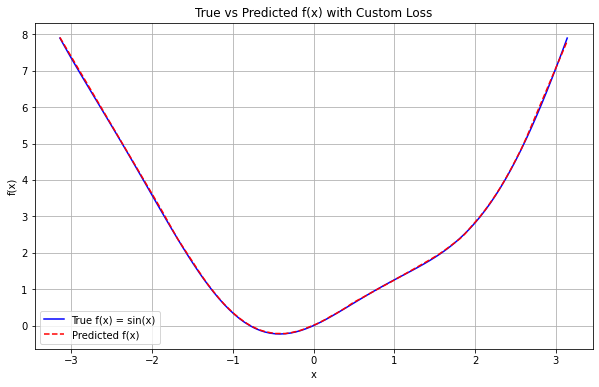

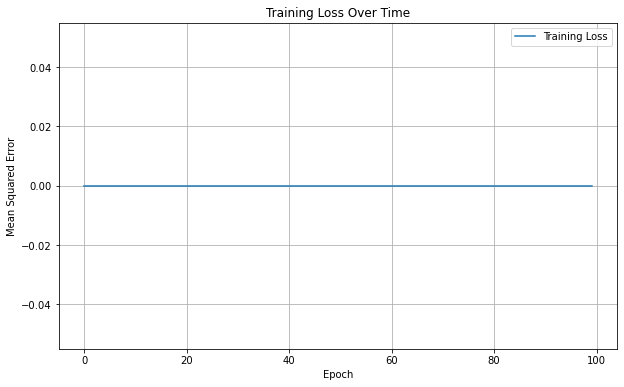

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define true functions
def f_true(x):
    return np.sin(x) * np.cos(x) + 0.8 * x**2

def g(y):
    return np.exp(-y**2)

def h(x, y):
    return f_true(x) * g(y)

# Generate sample data
np.random.seed(42)
n_samples = 1000
x_data = np.random.uniform(-np.pi, np.pi, n_samples)
y_data = np.random.uniform(-2, 2, n_samples)
h_data = h(x_data, y_data)
g_data = g(y_data)

# Prepare input data
# Inputs to the model are x and y, but y is used only in the custom loss
X_train = np.stack((x_data, y_data), axis=1)  # Shape: (n_samples, 2)
h_train = h_data.reshape(-1, 1)  # Shape: (n_samples, 1)
g_train = g_data.reshape(-1, 1)  # Shape: (n_samples, 1)

# Custom loss function
def custom_loss(y_true, y_pred, X, g_values):
    # y_pred is f(x), shape: (batch_size, 1)
    # y_true is h(x,y), shape: (batch_size, 1)
    # g_values is g(y), shape: (batch_size, 1)
    h_pred = y_pred * g_values  # Predicted h(x,y) = f(x) * g(y)
    return tf.reduce_mean(tf.square(h_pred - y_true))

# Build neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Input includes x and y, but we use only x
    tf.keras.layers.Lambda(lambda x: x[:, 0:1]),  # Extract x from input (x, y)
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output is f(x)
])

# Custom training step
class CustomModel(tf.keras.Model):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model

    def train_step(self, data):
        (x, g_vals), y = data  # x is (x_data, y_data), g_vals is g(y), y is h(x,y)
        with tf.GradientTape() as tape:
            y_pred = self.model(x, training=True)  # Predict f(x)
            loss = custom_loss(y, y_pred, x, g_vals)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        return {"loss": loss}

# Instantiate and compile custom model
custom_model = CustomModel(model)
custom_model.compile(optimizer='adam')

# Train model
# Pass (X_train, g_train) as input and h_train as target
history = custom_model.fit((X_train, g_train), h_train, epochs=100, batch_size=32, verbose=1)

# Evaluate model
x_test = np.linspace(-np.pi, np.pi, 100)
y_dummy = np.zeros_like(x_test)  # Dummy y values, not used in prediction
X_test = np.stack((x_test, y_dummy), axis=1)
f_pred = model.predict(X_test)
f_true_test = f_true(x_test)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test, f_true_test, label='True f(x) = sin(x)', color='blue')
plt.plot(x_test, f_pred, label='Predicted f(x)', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('True vs Predicted f(x) with Custom Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()